In [ ]:
rename_dict = {
    "Minas LDB U22": "Minas2025",
    "Caxias do Sul LDB U22": "Caxias2025",
    "Uniao Corinthians LDB U22": "União Corinthians2025",
    "BRB/Brasilia LDB U22": "Caixa Brasília Basquete2025",
    "Campo Mourao LDB U22": "Campo Mourão2025",
    "Mogi Basquete LDB U22": "Mogi2025",
    "Flamengo U22": "Flamengo2025",
    "Pinheiros U22": "Pinheiros2025",
    "IVV/CETAF LDB U22": "IVV/CETAF2025",
    "Sao Jose U22": "São José Basketball2025",
    "Botafogo RJ U22": "Botafogo2025",
    "Franca U22": "SESI Franca2025",
    "Basquete Cearense LDB U22": "B.Cearense2025",
    "Vasco da Gama/Tijuca LDB U22": "Vasco/Tijuca2025",
    "ADRM/Maringa LDB U22": "ADRM2025",
    "Paulistano U22": "Paulistano2025",
    "Sao Paulo LDB U22": "São Paulo FC2025",
    "Pato Basquete LDB U22": "Pato Basquete2025",
    "Soc. Thalia/SMEIJ LDB U22": "Thalia/PH.D Esportes2025",
    "Corinthians U22": "Corinthians2025",
    "Bauru LDB U22": "Bauru Basket2025",
    "Unifacisa LDB U22": "UNIFACISA2025",
    "Coritiba/Thalia LDB U22": "Thalia/PH.D Esportes2025",  
    "Mogi Das Cruzes U22": "Mogi2025",
}


In [ ]:
import pandas as pd
from datetime import datetime

In [ ]:
df = pd.read_csv('api/test_set.csv', parse_dates=['date'])
df = df[df['date'] > datetime(2025,7,28)]
df = df.sort_values(by='date')

In [ ]:
df

In [ ]:
# Aplicando o rename em ambas as colunas
df["home_team"] = df["home_team"].replace(rename_dict)
df["away_team"] = df["away_team"].replace(rename_dict)


In [ ]:
cols = [
    'date', 'home_team', 'away_team',
    'home_q1', 'away_q1',
    'home_final', 'away_final',
    'handicap', 'home_od', 'away_od',
    'handicap_3', 'over_od_3', 'under_od_3',
    'handicap_8', 'home_od_8', 'away_od_8'
    ]

df = df[cols].copy()


In [ ]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from pathlib import Path
import json, pickle, re, unicodedata, difflib
import numpy as np
import pandas as pd
import arviz as az

# =========================
# Caminhos (pasta do seu print)
# =========================
BASE_DIR = Path("models/v2")
META_DIR = BASE_DIR / "metadata"

# =========================
# Carregar artefatos do treino (índices corretos)
# =========================
with open(BASE_DIR / "idata.pkl", "rb") as f:
    idata = pickle.load(f)
with open(BASE_DIR / "stan_data.pkl", "rb") as f:
    stan_data = pickle.load(f)
with open(META_DIR / "team_index.json", "r", encoding="utf-8") as f:
    team_index = json.load(f)  # {team_hash: id}

# aliases opcionais (nome alternativo -> nome canônico)
team_alias = {}
alias_file = META_DIR / "team_alias.json"
if alias_file.exists():
    with open(alias_file, "r", encoding="utf-8") as f:
        team_alias = json.load(f)

Q = int(stan_data["Q"])  # nº de períodos (quartos)
T = int(stan_data["T"])

# sanity checks
assert "pace_home" in idata.posterior, "Variável 'pace_home' ausente no posterior."
assert idata.posterior["pace_home"].shape[-1] == T == len(team_index), \
       "T inconsistente entre posterior e metadata/team_index.json."

# =========================
# Helpers
# =========================
def _inv_logit(x):
    return 1.0 / (1.0 + np.exp(-x))

def _nb2_rng(mu, phi, rng):
    """NegBin2 (média mu, dispersão phi). Var = mu + mu^2/phi."""
    mu  = np.asarray(mu, dtype=float)
    phi = np.asarray(phi, dtype=float)
    p = np.clip(phi / (phi + mu), 1e-9, 1.0 - 1e-9)
    r = np.clip(phi, 1e-8, None)
    return rng.negative_binomial(r, p)

def _binom_rng(n, p, rng):
    n = np.asarray(n, dtype=int)
    p = np.clip(np.asarray(p, dtype=float), 1e-9, 1.0 - 1e-9)
    return rng.binomial(n, p)

# ---- normalização robusta de nomes ----
_punct_re = re.compile(r"[^a-z0-9 ]+")
_ws_re = re.compile(r"\s+")

def _strip_accents(s: str) -> str:
    nfkd = unicodedata.normalize("NFKD", s)
    return "".join(c for c in nfkd if not unicodedata.combining(c))

def _norm_name(x) -> str:
    x = str(x).strip().lower()
    x = _strip_accents(x)
    x = _punct_re.sub(" ", x)
    x = _ws_re.sub(" ", x).strip()
    return x

def _build_norm_maps(team_index: dict, team_alias: dict):
    norm2id = {}
    for name, tid in team_index.items():
        norm2id[_norm_name(name)] = int(tid)
    for alias, canonical in team_alias.items():
        if canonical in team_index:
            norm2id[_norm_name(alias)] = int(team_index[canonical])
    return norm2id

def _map_teams(df_in: pd.DataFrame, tmap: dict, team_alias: dict):
    norm2id = _build_norm_maps(tmap, team_alias)
    train_names = list(tmap.keys())
    train_norms = list(norm2id.keys())

    missing = []

    def _resolve_one(x):
        # exato
        if x in tmap:
            return int(tmap[x])
        # alias
        if x in team_alias and team_alias[x] in tmap:
            return int(tmap[team_alias[x]])
        # normalizado
        nx = _norm_name(x)
        if nx in norm2id:
            return norm2id[nx]
        missing.append(x)
        return None

    home_ids = [ _resolve_one(x) for x in df_in["home_team"] ]
    away_ids = [ _resolve_one(x) for x in df_in["away_team"] ]

    if missing:
        miss_unique = sorted({str(m) for m in missing})
        suggestions = {}
        for m in miss_unique:
            cand = difflib.get_close_matches(_norm_name(m), train_norms, n=3, cutoff=0.6)
            sug = []
            for c in cand:
                for tr_name in train_names:
                    if _norm_name(tr_name) == c:
                        sug.append(tr_name); break
            suggestions[m] = sug

        lines = ["Não foi possível mapear alguns times para IDs do treino:"]
        for m in miss_unique:
            sug = suggestions.get(m, [])
            hint = f" | sugestões: {', '.join(sug[:3])}" if sug else ""
            lines.append(f"  - '{m}'{hint}")
        lines.append("\nDica: adicione aliases em 'models/v2/metadata/team_alias.json', ex.:")
        lines.append('{ "Sao Jose": "São José Basketball2025", "Caxias": "Caxias2025" }')
        raise ValueError("\n".join(lines))

    return np.array(home_ids, dtype=int), np.array(away_ids, dtype=int)

def _extract_draws(idata: az.InferenceData, n_sims: int = 4000, seed: int = 123):
    """Empilha chain x draw em 'sample' e amostra as mesmas posições para todas as variáveis."""
    post = idata.posterior
    post_s = post.stack(sample=("chain", "draw"))
    S_full = post_s.sizes["sample"]
    rng = np.random.default_rng(seed)
    S = min(n_sims, S_full)
    idx = rng.choice(S_full, size=S, replace=False)

    def grab(name):
        if name not in post_s:
            raise KeyError(f"Variável '{name}' não encontrada em idata.posterior.")
        arr = post_s[name].transpose("sample", ...).values
        return arr[idx]

    return {
        # PACE
        "int_p":      grab("int_p"),
        "pace_home":  grab("pace_home"),
        "pace_away":  grab("pace_away"),
        "rho_p":      grab("rho_p"),
        "sd_init":    grab("sd_init"),
        "sd_state":   grab("sd_state"),
        "phi_pace":   grab("phi_pace"),
        # TENTATIVAS
        "int_2a":     grab("int_2a"),
        "int_3a":     grab("int_3a"),
        "int_fta":    grab("int_fta"),
        "beta_q_2a":  grab("beta_q_2a"),
        "beta_q_3a":  grab("beta_q_3a"),
        "beta_q_fta": grab("beta_q_fta"),
        "atk_2a":     grab("atk_2a"),
        "def_2a":     grab("def_2a"),
        "atk_3a":     grab("atk_3a"),
        "def_3a":     grab("def_3a"),
        "atk_fta":    grab("atk_fta"),
        "def_fta":    grab("def_fta"),
        "phi_2a":     grab("phi_2a"),
        "phi_3a":     grab("phi_3a"),
        "phi_fta":    grab("phi_fta"),
        # EFICIÊNCIA
        "int_2m":     grab("int_2m"),
        "int_3m":     grab("int_3m"),
        "int_ftm":    grab("int_ftm"),
        "beta_q_2m":  grab("beta_q_2m"),
        "beta_q_3m":  grab("beta_q_3m"),
        "beta_q_ftm": grab("beta_q_ftm"),
        "atk_2m":     grab("atk_2m"),
        "def_2m":     grab("def_2m"),
        "atk_3m":     grab("atk_3m"),
        "def_3m":     grab("def_3m"),
        "atk_ftm":    grab("atk_ftm"),
        "def_ftm":    grab("def_ftm"),
    }, idx

def simulate_oos_from_df(df_in: pd.DataFrame, idata: az.InferenceData,
                         team_index: dict, team_alias: dict,
                         n_sims: int = 4000, seed: int = 2025):
    """
    Simula OOS para 'df_in' (precisa de 'home_team' e 'away_team').
    Calcula:
      - pr_home_win
      - pr_home_cover (spread do jogo inteiro, col 'handicap')
      - pr_total_gt_handicap_3 (over do total do jogo, col 'handicap_3')
      - pr_home_cover_q1_handicap_8 (spread do Q1, col 'handicap_8')
    """
    for col in ["home_team", "away_team"]:
        if col not in df_in.columns:
            raise ValueError(f"Coluna obrigatória ausente em df: '{col}'")

    draws, idx = _extract_draws(idata, n_sims=n_sims, seed=seed)
    S = len(idx)
    G = len(df_in)

    home_id, away_id = _map_teams(df_in, team_index, team_alias)
    home0 = home_id - 1
    away0 = away_id - 1

    rng = np.random.default_rng(seed)

    # Estado AR(1) do pace por jogo (S,G,Q)
    s = np.zeros((S, G, Q))
    s[:, :, 0] = draws["sd_init"][:, None] * rng.normal(0, 1, size=(S, G))
    if Q > 1:
        noise = rng.normal(0, 1, size=(S, G, Q - 1))
        for q in range(1, Q):
            s[:, :, q] = draws["rho_p"][:, None] * s[:, :, q-1] + draws["sd_state"][:, None] * noise[:, :, q-1]

    # log-pace & posses (S,G,Q)
    eta_pace = (draws["int_p"][:, None, None]
                + draws["pace_home"][:, home0][:, :, None]
                + draws["pace_away"][:, away0][:, :, None]
                + s)
    mu_poss = np.exp(eta_pace)
    log_mu_poss = np.log(mu_poss + 1e-12)

    # Função genérica (2P/3P/FT)
    def attempts_and_makes(int_a, atk_a, def_a, beta_q_a, phi_a,
                           int_m, atk_m, def_m, beta_q_m):
        # HOME
        eta_h = (int_a[:, None, None] + log_mu_poss
                 + atk_a[:, home0][:, :, None]
                 + def_a[:, away0][:, :, None]
                 + beta_q_a[:, None, :])
        y_att_h = _nb2_rng(np.exp(eta_h), phi_a[:, None, None], rng)

        z_h = (int_m[:, None, None]
               + atk_m[:, home0][:, :, None]
               + def_m[:, away0][:, :, None]
               + beta_q_m[:, None, :])
        p_h = _inv_logit(z_h)
        y_m_h = _binom_rng(y_att_h, p_h, rng)

        # AWAY
        eta_a = (int_a[:, None, None] + log_mu_poss
                 + atk_a[:, away0][:, :, None]
                 + def_a[:, home0][:, :, None]
                 + beta_q_a[:, None, :])
        y_att_a = _nb2_rng(np.exp(eta_a), phi_a[:, None, None], rng)

        z_a = (int_m[:, None, None]
               + atk_m[:, away0][:, :, None]
               + def_m[:, home0][:, :, None]
               + beta_q_m[:, None, :])
        p_a = _inv_logit(z_a)
        y_m_a = _binom_rng(y_att_a, p_a, rng)

        return y_att_h, y_m_h, y_att_a, y_m_a

    # 2P / 3P / FT
    y2a_h, y2m_h, y2a_a, y2m_a = attempts_and_makes(
        draws["int_2a"], draws["atk_2a"], draws["def_2a"], draws["beta_q_2a"], draws["phi_2a"],
        draws["int_2m"], draws["atk_2m"], draws["def_2m"], draws["beta_q_2m"])
    y3a_h, y3m_h, y3a_a, y3m_a = attempts_and_makes(
        draws["int_3a"], draws["atk_3a"], draws["def_3a"], draws["beta_q_3a"], draws["phi_3a"],
        draws["int_3m"], draws["atk_3m"], draws["def_3m"], draws["beta_q_3m"])
    yfa_h, yfm_h, yfa_a, yfm_a = attempts_and_makes(
        draws["int_fta"], draws["atk_fta"], draws["def_fta"], draws["beta_q_fta"], draws["phi_fta"],
        draws["int_ftm"], draws["atk_ftm"], draws["def_ftm"], draws["beta_q_ftm"])

    # Pontos por quarto e totais
    pts_h_q = 2*y2m_h + 3*y3m_h + yfm_h   # (S,G,Q)
    pts_a_q = 2*y2m_a + 3*y3m_a + yfm_a
    pts_h   = pts_h_q.sum(axis=2)         # (S,G)
    pts_a   = pts_a_q.sum(axis=2)
    tot     = pts_h + pts_a
    diff    = pts_h - pts_a

    # Saída alinhada ao df original
    def pctile(x, q): return np.percentile(x, q, axis=0)

    out = pd.DataFrame({
        "pr_home_win": (pts_h > pts_a).mean(axis=0),
        "home_mean":   pts_h.mean(axis=0),
        "away_mean":   pts_a.mean(axis=0),
        "total_mean":  tot.mean(axis=0),
        "diff_mean":   diff.mean(axis=0),
        "home_p50":    pctile(pts_h, 50),
        "away_p50":    pctile(pts_a, 50),
        "total_p50":   pctile(tot, 50),
    }, index=df_in.index)

    # ---------- Probabilidades pedidas ----------
    # 1) Spread de jogo inteiro
    if "handicap" in df_in.columns:
        hc = df_in["handicap"].to_numpy()
        pr = np.full(G, np.nan)
        mask = np.isfinite(hc)
        if mask.any():
            pr[mask] = (pts_h[:, mask] + hc[mask] > pts_a[:, mask]).mean(axis=0)
        out["pr_home_cover"] = pr

    # 2) OVER do total do jogo (handicap_3)
    if "handicap_3" in df_in.columns:
        h3 = df_in["handicap_3"].to_numpy()
        pr3 = np.full(G, np.nan)
        mask3 = np.isfinite(h3)
        if mask3.any():
            pr3[mask3] = (tot[:, mask3] > h3[mask3]).mean(axis=0)
        out["pr_total_gt_handicap_3"] = pr3

    # 3) Spread do 1º quarto (handicap_8): home_Q1 + h8 > away_Q1
    if "handicap_8" in df_in.columns and Q >= 1:
        h8 = df_in["handicap_8"].to_numpy()
        pr8 = np.full(G, np.nan)
        mask8 = np.isfinite(h8)
        if mask8.any():
            home_q1 = pts_h_q[:, mask8, 0]
            away_q1 = pts_a_q[:, mask8, 0]
            pr8[mask8] = (home_q1 + h8[mask8] > away_q1).mean(axis=0)
        out["pr_home_cover_q1_handicap_8"] = pr8

    df_pred = pd.concat([df_in, out], axis=1)
    raw = {
        "pts_home": pts_h, "pts_away": pts_a, "total": tot, "diff": diff,
        "pts_home_q": pts_h_q, "pts_away_q": pts_a_q
    }
    return df_pred, raw

# =========================================
# RODAR (usa o df que JÁ existe no ambiente)
# =========================================
df_pred, raw = simulate_oos_from_df(
    df, idata=idata, team_index=team_index, team_alias=team_alias, n_sims=4000, seed=2025
)

# Exemplo rápido de visualização
cols = [
    "date","home_team","away_team",
    "home_mean","away_mean","total_mean","pr_home_win",
]
if "handicap" in df_pred.columns:   cols.append("pr_home_cover")
if "handicap_3" in df_pred.columns: cols.append("pr_total_gt_handicap_3")
if "handicap_8" in df_pred.columns: cols.append("pr_home_cover_q1_handicap_8")
print(df_pred[cols].head())

# (opcional) salvar
# df_pred.to_parquet("predicoes_outofsample.parquet", index=False)


In [ ]:
pip install openpyxl

In [ ]:
df_pred.to_excel('pred.xlsx', index=False)

In [34]:
# -*- coding: utf-8 -*-
"""
Simulador de um confronto (home_team vs away_team) com gráficos de distribuição
das pontuações simuladas para cada equipe, usando o modelo treinado em models/v2.

Uso:
    python simulate_matchup.py

Ou, dentro de um notebook/python:
    run_matchup("Pinheiros2025", "Caxias2025", n_sims=5000, seed=2025)
"""

from __future__ import annotations
from pathlib import Path
import json, pickle, re, unicodedata, difflib
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ============ Caminhos ============
BASE_DIR = Path("models/v2")
META_DIR = BASE_DIR / "metadata"

# ============ Carrega artefatos ============
with open(BASE_DIR / "idata.pkl", "rb") as f:
    IDATA = pickle.load(f)
with open(BASE_DIR / "stan_data.pkl", "rb") as f:
    STAN_DATA = pickle.load(f)
with open(META_DIR / "team_index.json", "r", encoding="utf-8") as f:
    TEAM_INDEX = json.load(f)  # {team_hash: id}

TEAM_ALIAS = {}
alias_file = META_DIR / "team_alias.json"
if alias_file.exists():
    with open(alias_file, "r", encoding="utf-8") as f:
        TEAM_ALIAS = json.load(f)

Q = int(STAN_DATA["Q"])
T = int(STAN_DATA["T"])
assert "pace_home" in IDATA.posterior, "Variável 'pace_home' não encontrada no posterior."
assert IDATA.posterior["pace_home"].shape[-1] == T == len(TEAM_INDEX), \
       "T inconsistente entre posterior e metadata/team_index.json."

# ============ Helpers ============

# normalização para casar nomes externos com os do treino
_PUNCT = re.compile(r"[^a-z0-9 ]+")
_WS = re.compile(r"\s+")
def _strip_accents(s: str) -> str:
    nfkd = unicodedata.normalize("NFKD", s)
    return "".join(c for c in nfkd if not unicodedata.combining(c))
def _norm_name(x: str) -> str:
    x = str(x).strip().lower()
    x = _strip_accents(x)
    x = _PUNCT.sub(" ", x)
    x = _WS.sub(" ", x).strip()
    return x

def _build_norm_map(team_index: dict, team_alias: dict):
    norm2id = { _norm_name(name): int(tid) for name, tid in team_index.items() }
    for alias, canonical in team_alias.items():
        if canonical in team_index:
            norm2id[_norm_name(alias)] = int(team_index[canonical])
    return norm2id

def _resolve_team_id(name: str, team_index: dict, team_alias: dict) -> int:
    # 1) exato
    if name in team_index:
        return int(team_index[name])
    # 2) alias canônico
    if name in team_alias and team_alias[name] in team_index:
        return int(team_index[team_alias[name]])
    # 3) normalizado
    norm2id = _build_norm_map(team_index, team_alias)
    nx = _norm_name(name)
    if nx in norm2id:
        return norm2id[nx]
    # 4) sugestões
    train_norms = list(norm2id.keys())
    cand = difflib.get_close_matches(nx, train_norms, n=5, cutoff=0.6)
    suggestions = []
    if cand:
        # traduz normalizado -> nome original legível
        for c in cand:
            for k, v in team_index.items():
                if _norm_name(k) == c:
                    suggestions.append(k); break
    msg = [f"Time não encontrado no treino: '{name}'"]
    if suggestions:
        msg.append("Sugestões: " + ", ".join(suggestions[:5]))
    msg.append("Você pode adicionar aliases em models/v2/metadata/team_alias.json")
    raise ValueError("\n".join(msg))

def _stack_draws(idata: az.InferenceData, n_sims=5000, seed=2025):
    post = idata.posterior
    post_s = post.stack(sample=("chain", "draw"))
    S_full = post_s.sizes["sample"]
    rng = np.random.default_rng(seed)
    S = min(n_sims, S_full)
    idx = rng.choice(S_full, size=S, replace=False)
    def g(name):
        if name not in post_s:
            raise KeyError(f"Variável '{name}' ausente no posterior.")
        arr = post_s[name].transpose("sample", ...).values  # 'sample' primeiro
        return arr[idx]
    return {
        # pace
        "int_p": g("int_p"),
        "pace_home": g("pace_home"),  # (S,T)
        "pace_away": g("pace_away"),
        "rho_p": g("rho_p"),
        "sd_init": g("sd_init"),
        "sd_state": g("sd_state"),
        # tentativas
        "int_2a": g("int_2a"), "int_3a": g("int_3a"), "int_fta": g("int_fta"),
        "beta_q_2a": g("beta_q_2a"), "beta_q_3a": g("beta_q_3a"), "beta_q_fta": g("beta_q_fta"),
        "atk_2a": g("atk_2a"), "def_2a": g("def_2a"),
        "atk_3a": g("atk_3a"), "def_3a": g("def_3a"),
        "atk_fta": g("atk_fta"), "def_fta": g("def_fta"),
        "phi_2a": g("phi_2a"), "phi_3a": g("phi_3a"), "phi_fta": g("phi_fta"),
        # eficiência
        "int_2m": g("int_2m"), "int_3m": g("int_3m"), "int_ftm": g("int_ftm"),
        "beta_q_2m": g("beta_q_2m"), "beta_q_3m": g("beta_q_3m"), "beta_q_ftm": g("beta_q_ftm"),
        "atk_2m": g("atk_2m"), "def_2m": g("def_2m"),
        "atk_3m": g("atk_3m"), "def_3m": g("def_3m"),
        "atk_ftm": g("atk_ftm"), "def_ftm": g("def_ftm"),
    }, idx

def _inv_logit(x): return 1.0 / (1.0 + np.exp(-x))
def _nb2_rng(mu, phi, rng):
    mu  = np.asarray(mu, dtype=float)
    phi = np.asarray(phi, dtype=float)
    p = np.clip(phi / (phi + mu), 1e-9, 1.0 - 1e-9)
    r = np.clip(phi, 1e-8, None)
    return rng.negative_binomial(r, p)
def _binom_rng(n, p, rng):
    n = np.asarray(n, dtype=int)
    p = np.clip(np.asarray(p, dtype=float), 1e-9, 1.0 - 1e-9)
    return rng.binomial(n, p)

def _simulate_matchup(home_id: int, away_id: int, draws: dict, seed=2025):
    """
    Simula um único confronto (home_id vs away_id) por S amostras do posterior.
    Retorna arrays (S,) com pontos do mandante e visitante e também (S,Q) por quarto.
    """
    S = draws["int_p"].shape[0]
    home0 = home_id - 1
    away0 = away_id - 1
    rng = np.random.default_rng(seed)

    # Estado AR(1) (S,Q)
    s = np.zeros((S, Q))
    s[:, 0] = draws["sd_init"] * rng.normal(0, 1, size=S)
    for q in range(1, Q):
        s[:, q] = draws["rho_p"] * s[:, q-1] + draws["sd_state"] * rng.normal(0, 1, size=S)

    # log-pace & posses (S,Q)
    eta_pace = (draws["int_p"][:, None]
                + draws["pace_home"][:, home0][:, None]
                + draws["pace_away"][:, away0][:, None]
                + s)
    mu_poss = np.exp(eta_pace)
    log_mu_poss = np.log(mu_poss + 1e-12)

    def attempts_and_makes(int_a, atk_a, def_a, beta_q_a, phi_a,
                           int_m, atk_m, def_m, beta_q_m):
        # home
        eta_h = (int_a[:, None] + log_mu_poss
                 + atk_a[:, home0][:, None]
                 + def_a[:, away0][:, None]
                 + beta_q_a)
        y_att_h = _nb2_rng(np.exp(eta_h), phi_a[:, None], rng)

        z_h = (int_m[:, None]
               + atk_m[:, home0][:, None]
               + def_m[:, away0][:, None]
               + beta_q_m)
        p_h = _inv_logit(z_h)
        y_m_h = _binom_rng(y_att_h, p_h, rng)

        # away
        eta_a = (int_a[:, None] + log_mu_poss
                 + atk_a[:, away0][:, None]
                 + def_a[:, home0][:, None]
                 + beta_q_a)
        y_att_a = _nb2_rng(np.exp(eta_a), phi_a[:, None], rng)

        z_a = (int_m[:, None]
               + atk_m[:, away0][:, None]
               + def_m[:, home0][:, None]
               + beta_q_m)
        p_a = _inv_logit(z_a)
        y_m_a = _binom_rng(y_att_a, p_a, rng)

        return y_att_h, y_m_h, y_att_a, y_m_a

    # 2P / 3P / FT
    y2a_h, y2m_h, y2a_a, y2m_a = attempts_and_makes(
        draws["int_2a"], draws["atk_2a"], draws["def_2a"], draws["beta_q_2a"], draws["phi_2a"],
        draws["int_2m"], draws["atk_2m"], draws["def_2m"], draws["beta_q_2m"])
    y3a_h, y3m_h, y3a_a, y3m_a = attempts_and_makes(
        draws["int_3a"], draws["atk_3a"], draws["def_3a"], draws["beta_q_3a"], draws["phi_3a"],
        draws["int_3m"], draws["atk_3m"], draws["def_3m"], draws["beta_q_3m"])
    yfa_h, yfm_h, yfa_a, yfm_a = attempts_and_makes(
        draws["int_fta"], draws["atk_fta"], draws["def_fta"], draws["beta_q_fta"], draws["phi_fta"],
        draws["int_ftm"], draws["atk_ftm"], draws["def_ftm"], draws["beta_q_ftm"])

    # Pontos
    pts_h_q = 2*y2m_h + 3*y3m_h + yfm_h   # (S,Q)
    pts_a_q = 2*y2m_a + 3*y3m_a + yfm_a
    pts_h   = pts_h_q.sum(axis=1)         # (S,)
    pts_a   = pts_a_q.sum(axis=1)

    return pts_h, pts_a, pts_h_q, pts_a_q

def run_matchup(home_team: str, away_team: str, n_sims=5000, seed=2025, show_total=False):
    """Resolve IDs dos times, simula e plota as distribuições de pontuação."""
    home_id = _resolve_team_id(home_team, TEAM_INDEX, TEAM_ALIAS)
    away_id = _resolve_team_id(away_team, TEAM_INDEX, TEAM_ALIAS)
    draws, _ = _stack_draws(IDATA, n_sims=n_sims, seed=seed)

    pts_h, pts_a, pts_h_q, pts_a_q = _simulate_matchup(home_id, away_id, draws, seed=seed)

    # resumo rápido
    pr_home_win = float(np.mean(pts_h > pts_a))
    print(f"Simulações: {len(pts_h)} | P(home win): {pr_home_win:.3f}")
    print(f"{home_team} — média: {pts_h.mean():.2f}, mediana: {np.median(pts_h):.1f}")
    print(f"{away_team} — média: {pts_a.mean():.2f}, mediana: {np.median(pts_a):.1f}")

    # --- NOVO: diferença e total ---
    diff = pts_h - pts_a
    total = pts_h + pts_a
    med_diff = np.median(diff)
    med_total = np.median(total)

    print(f"Mediana da diferença de pontos ({home_team} - {away_team}): {med_diff:.1f}")
    print(f"Mediana do total de pontos: {med_total:.1f}")

    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # --- KDE Home vs Away (sobrepostos) ---
    kde_h = gaussian_kde(pts_h)
    x_h = np.linspace(min(pts_h), max(pts_h), 300)
    y_h = kde_h(x_h)

    kde_a = gaussian_kde(pts_a)
    x_a = np.linspace(min(pts_a), max(pts_a), 300)
    y_a = kde_a(x_a)

    plt.figure(figsize=(6, 3))
    plt.plot(x_h, y_h, color="C0", label='Mandante')
    plt.fill_between(x_h, y_h, alpha=0.3, color="C0")


    plt.plot(x_a, y_a, color="C1", label='Visitante')
    plt.fill_between(x_a, y_a, alpha=0.3, color="C1")


    plt.title(f"Distribuição de pontos")
    plt.xlabel("Pontos"); plt.ylabel("Densidade")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- KDE Diferença ---
    kde_d = gaussian_kde(diff)
    x_d = np.linspace(min(diff), max(diff), 300)
    y_d = kde_d(x_d)

    plt.figure(figsize=(6, 3))
    plt.plot(x_d, y_d, color="C2", label="Diferença (home - away)")
    plt.fill_between(x_d, y_d, alpha=0.3, color="C2")
    plt.axvline(med_diff, linestyle=":", color="C2", label=f"Mediana: {med_diff:.1f}")
    plt.title(f"Diferença de pts")
    plt.xlabel("Diferença de pontos"); plt.ylabel("Densidade")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- KDE Total ---
    kde_t = gaussian_kde(total)
    x_t = np.linspace(min(total), max(total), 300)
    y_t = kde_t(x_t)

    plt.figure(figsize=(6, 3))
    plt.plot(x_t, y_t, color="C3", label="Total de pontos")
    plt.fill_between(x_t, y_t, alpha=0.3, color="C3")
    plt.axvline(med_total, linestyle=":", color="C3", label=f"Mediana: {med_total:.1f}")
    plt.title("Distribuição do total de pontos")
    plt.xlabel("Total de pontos"); plt.ylabel("Densidade")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    return {
        "pts_home": pts_h, "pts_away": pts_a,
        "pts_home_q": pts_h_q, "pts_away_q": pts_a_q,
        "pr_home_win": pr_home_win,
        "median_diff": med_diff,
        "median_total": med_total
    }


Simulações: 8000 | P(home win): 0.583
Thalia/PH.D Esportes2025 — média: 70.78, mediana: 70.0
Vasco/Tijuca2025 — média: 66.05, mediana: 65.0
Mediana da diferença de pontos (Thalia/PH.D Esportes2025 - Vasco/Tijuca2025): 5.0
Mediana do total de pontos: 136.0


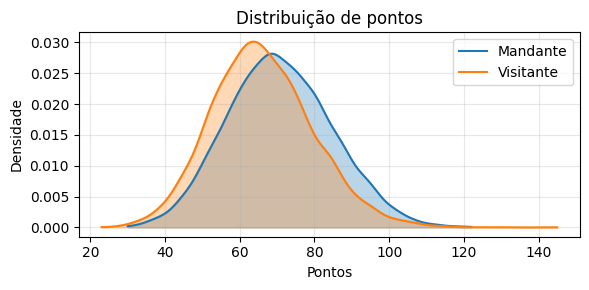

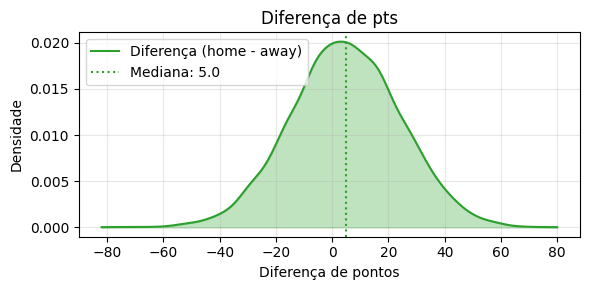

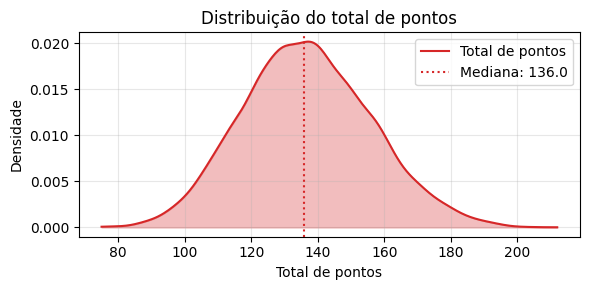

In [35]:
# --- Exemplo de uso (descomente e troque pelos times que você quiser) ---
out = run_matchup("Thalia/PH.D Esportes2025", "Vasco/Tijuca2025", n_sims=25000, seed=2022, show_total=True)